In [72]:
import itertools
import ast
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd
import operator
import collections

In [2]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            with open(filepath) as f:
                for line1,line2 in itertools.izip_longest(*[f]*2):
                    try:
                        text = ast.literal_eval(line1)
                        label = ast.literal_eval(line2)
                        n_labels = set(label)
                        
                        if len(text) > 3 and len(n_labels) > 1:
                            sentence = zip(text, label)
                            sentence.append(('.', 'O'))
                            sentence = [item for item in sentence if item[0].strip() != '']
                            data_list.append(sentence)
                    except:
                        pass
            f.close()
    return data_list

### GO Data - Read input

In [7]:
data_list_go = read_data('../../data/input/GO/merged/')

#get all of the tags into a list contains 'O'
tags = list(y[1] for x in data_list_go for y in x)



In [8]:
from collections import Counter

tag_freq = Counter(tags)

In [9]:
tag_freq

Counter({'GO:0000003': 410,
         'GO:0000075': 31,
         'GO:0000237': 7,
         'GO:0000238': 4,
         'GO:0000239': 90,
         'GO:0000240': 38,
         'GO:0000267': 25,
         'GO:0000279': 1,
         'GO:0000502': 1,
         'GO:0000718': 2,
         'GO:0000732': 39,
         'GO:0000775': 11,
         'GO:0000785': 87,
         'GO:0000786': 9,
         'GO:0000791': 4,
         'GO:0000792': 70,
         'GO:0000795': 8,
         'GO:0000805': 21,
         'GO:0000806': 7,
         'GO:0000811': 1,
         'GO:0001501': 6,
         'GO:0001503': 24,
         'GO:0001525': 1,
         'GO:0001570': 2,
         'GO:0001669': 1,
         'GO:0001708': 13,
         'GO:0001709': 4,
         'GO:0001750': 4,
         'GO:0001756': 1,
         'GO:0001763': 28,
         'GO:0001775': 41,
         'GO:0001822': 9,
         'GO:0001837': 2,
         'GO:0001889': 1,
         'GO:0001917': 18,
         'GO:0001944': 2,
         'GO:0001947': 1,
         'GO:0001966':

In [11]:
tag_freq.pop('O', None)

In [18]:
tag_keys = list(tag_freq.keys())
tag_vals = np.fromiter(tag_freq.values(), dtype=float)

In [22]:
ranges = range(10,101, 10)
ranges

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [29]:
tag_bins = pd.cut(tag_vals, 10, labels=ranges)
print tag_bins

[10, 10, 10, 10, 10, ..., 10, 10, 10, 10, 10]
Length: 358
Categories (10, int64): [10 < 20 < 30 < 40 ... 70 < 80 < 90 < 100]


In [26]:
bin_freq = Counter(tag_bins)

In [27]:
bin_freq

Counter({10: 345, 20: 8, 30: 1, 40: 1, 50: 1, 80: 1, 100: 1})

In [35]:
tag_dict = {}

for i in range(len(tag_bins)):
    tag_dict[tag_keys[i]] = {
        'freq': tag_vals[i],
        'bin' : tag_bins[i],
        'err':0
    }
print tag_dict

{'GO:0007599': {'bin': 10, 'freq': 11.0, 'err': 0}, 'GO:0007596': {'bin': 10, 'freq': 28.0, 'err': 0}, 'GO:0006900': {'bin': 10, 'freq': 4.0, 'err': 0}, 'GO:0001501': {'bin': 10, 'freq': 6.0, 'err': 0}, 'GO:0001503': {'bin': 10, 'freq': 24.0, 'err': 0}, 'GO:0006909': {'bin': 10, 'freq': 36.0, 'err': 0}, 'GO:0001966': {'bin': 10, 'freq': 1.0, 'err': 0}, 'GO:0000003': {'bin': 20, 'freq': 410.0, 'err': 0}, 'GO:0043209': {'bin': 10, 'freq': 13.0, 'err': 0}, 'GO:0005835': {'bin': 10, 'freq': 1.0, 'err': 0}, 'GO:0005833': {'bin': 10, 'freq': 2.0, 'err': 0}, 'GO:0016458': {'bin': 10, 'freq': 18.0, 'err': 0}, 'GO:0016459': {'bin': 10, 'freq': 4.0, 'err': 0}, 'GO:0018032': {'bin': 10, 'freq': 2.0, 'err': 0}, 'GO:0006281': {'bin': 10, 'freq': 85.0, 'err': 0}, 'GO:0006289': {'bin': 10, 'freq': 10.0, 'err': 0}, 'GO:0007283': {'bin': 10, 'freq': 11.0, 'err': 0}, 'GO:0007286': {'bin': 10, 'freq': 1.0, 'err': 0}, 'GO:0001756': {'bin': 10, 'freq': 1.0, 'err': 0}, 'GO:0001750': {'bin': 10, 'freq': 4.0,

## Read Output (Predictions)

In [47]:
df = pd.read_csv('../../data/results/CW-BiGRU_GO.tsv', sep='\t')
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,Ground Truth,Predicted,Word
0,O,O,Our
1,O,O,present
2,O,O,results
3,O,O,suggest
4,O,O,that


In [49]:
truth = df['Ground Truth'].tolist()
pred = df['Predicted'].tolist()

In [50]:
for j in range(len(truth)):
    if truth[j] != 'O':
        if truth[j] != pred[j]:
            tag_dict[truth[j]]['err'] += 1

In [74]:
err_data = list(tag_dict.values())

err_dict = dict((x,0) for x in ranges)
freq_dict = dict((x,0) for x in ranges)

for each in err_data:
    err_dict[each['bin']] += each['err']
    freq_dict[each['bin']] += each['freq']
    
print err_dict

print freq_dict

{100: 0, 70: 0, 40: 37, 10: 453, 80: 0, 50: 25, 20: 89, 90: 0, 60: 0, 30: 18}
{100: 2891.0, 70: 0, 40: 1131.0, 10: 8529.0, 80: 2056.0, 50: 1158.0, 20: 3109.0, 90: 0, 60: 0, 30: 595.0}


In [108]:
err_list = list(sorted(err_dict.items()))
freq_list = list(sorted(freq_dict.items()))

print freq_list
print err_list
err_X = []
err_Y = []

freq_X = []
freq_Y = []


for k in range(len(freq_list)):
    if freq_list[k][1] != 0:
            err_X.append(err_list[k][0])
            err_Y.append(err_list[k][1])
    
            freq_X.append(freq_list[k][0])
            freq_Y.append(freq_list[k][1])



[(10, 8529.0), (20, 3109.0), (30, 595.0), (40, 1131.0), (50, 1158.0), (60, 0), (70, 0), (80, 2056.0), (90, 0), (100, 2891.0)]
[(10, 453), (20, 89), (30, 18), (40, 37), (50, 25), (60, 0), (70, 0), (80, 0), (90, 0), (100, 0)]


In [86]:
%matplotlib inline

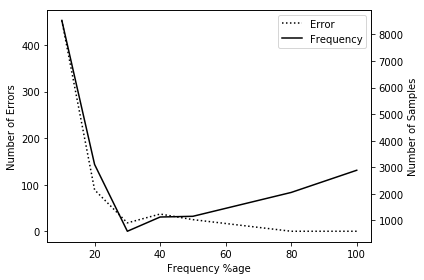

In [135]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

lns1 = ax1.plot(err_X, err_Y, label = 'Error', linestyle=':', color='black')
ax1.set_xlabel('Frequency %age')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Number of Errors', color='black')
ax1.tick_params('y', colors='black')

ax2 = ax1.twinx()

lns2 = ax2.plot(freq_X, freq_Y, label = 'Frequency', linestyle='-', color='black')
ax2.set_ylabel('Number of Samples', color='black')
ax2.tick_params('y', colors='black')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
# handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles, ['Error', 'Frequency'], loc="upper right")

fig.tight_layout()

plt.savefig('../../data/results/error_freq.eps',dpi=1200)